In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
print("Using PyTorch Version %s" %torch.__version__)
plt.rcParams.update({'font.size':16})
plt.rcParams.update({'figure.autolayout': True})

Using PyTorch Version 1.4.0


In [2]:
### Datasets ###

dataset = 2 # each dataset contains the global snapshot array as well as the number of snapshots per trajectory and the number of trajectories

# add new datasets as below
if dataset == 0: 
    file_dir = 'toggle_switch_data.p'
    
if dataset == 1: 
    file_dir = 'toggle_switch_data_normed.p'
    
if dataset == 2: 
    file_dir = 'stable_linsys.p'


In [3]:
data,nT,nTraj = pickle.load(open(file_dir,'rb'))
trainData = torch.Tensor(data[:,0:int(data.shape[1]/2)].T)
testData = torch.Tensor(data[:,int(data.shape[1]/2):int(data.shape[1])].T)

print('Dimension of the state: ' + str(trainData.shape[1]));
print('Number of trajectories: ' + str(nTraj));
print('Number of total snapshots: ' + str(data.shape[1]));
print('Number of training snapshots: ' + str(trainData.shape[0]));
print('Number of test snapshots: ' + str(testData.shape[0]));

Dimension of the state: 2
Number of trajectories: 100
Number of total snapshots: 10000
Number of training snapshots: 5000
Number of test snapshots: 5000


In [24]:
### Neural network parameters ###

NUM_INPUTS = trainData.shape[1] # dimension of input
NUM_HL = 3 # number of hidden layers (excludes the input and output layers)
NODES_HL = 1 # number of nodes per hidden layer (number of learned observables)
HL_SIZES = [NODES_HL for i in range(0,NUM_HL+1)] 
NUM_OUTPUTS = NUM_INPUTS + HL_SIZES[-1] + 1 # output layer takes in dimension of input + 1 + dimension of hl's
BATCH_SIZE = int(nT/10)


In [25]:
class Net(nn.Module):
    
    def __init__(self, input_dim, output_dim, hl_sizes):
        super(Net, self).__init__()
        current_dim = input_dim
        self.linears = nn.ModuleList()
        for hl_dim in hl_sizes:
            self.linears.append(nn.Linear(current_dim, hl_dim))
            current_dim = hl_dim
        self.linears.append(nn.Linear(output_dim, output_dim,bias=False))

    def forward(self, x):
        input_vecs = x
        for layer in self.linears[:-1]:
            x = F.relu(layer(x))
        y = torch.cat((torch.Tensor(np.ones((x.shape[0],1))),input_vecs,x),dim=1)
        x = self.linears[-1](y)
        return {'KPsiXp':x,'PsiXf':y} 

net = Net(NUM_INPUTS,NUM_OUTPUTS,HL_SIZES)
print(net)

Net(
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=1, bias=True)
    (1): Linear(in_features=1, out_features=1, bias=True)
    (2): Linear(in_features=1, out_features=1, bias=True)
    (3): Linear(in_features=1, out_features=1, bias=True)
    (4): Linear(in_features=4, out_features=4, bias=False)
  )
)


In [26]:
# Defining the loss function and the optimizer

LEARNING_RATE = 0.025
L2_REG = 0.0
MOMENTUM = 0.0

loss_func = nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(),lr=LEARNING_RATE,momentum=MOMENTUM,weight_decay=L2_REG)

In [27]:
# Train the network 
print_less_often = 20
eps = 1e-14
train_loss = []
maxEpochs = 10000
prev_loss = 0
curr_loss = 1e10
epoch = 0
m = 20 # BATCH_SIZE # prediction window for loss function, can't exceed nT
numDatapoints = trainData.shape[0]
net.train()
while (np.abs(curr_loss-prev_loss) > eps) and (epoch <= maxEpochs):
    prev_loss = curr_loss
    for i in range(0,trainData.shape[0],BATCH_SIZE):
        
        Kpsixp = net(trainData[i:i+BATCH_SIZE-1])['KPsiXp'] 
        psixf = net(trainData[i+1:i+BATCH_SIZE])['PsiXf']
        loss = loss_func(psixf, Kpsixp) 
        
#         pred_init_ind = np.random.randint(0,numDatapoints-m-10)
#         psix0 = net(trainData[i:i+10])['psi_xf'] 
#         psixm = net(trainData[i+m-1:i+m])['psi_xf']
#         K = net.fcLast.weight[:]
#         loss = loss_func(psixf,Kpsixp) + loss_func(psixm,psix0@(torch.matrix_power(K,m)))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    curr_loss = loss.item()
    if epoch % print_less_often == 0:
        print('['+str(epoch)+']'+' loss = '+str(loss.item()))
        train_loss.append(loss.item()) 
    epoch+=1
print('['+str(epoch)+']'+' loss = '+ str(loss.item()))

[0] loss = 4.9805814342107624e-05
[10] loss = 2.880715956575519e-13


In [28]:
K = net.linears[-1].weight[:].detach().numpy()


In [30]:
# a quick test
net.eval()
Kpsixp_test = net(testData[nT-2:nT-1])['KPsiXp']
psixf_test = net(testData[nT-1:nT])['PsiXf']
print(Kpsixp_test)
print(psixf_test)


tensor([[ 1.0000e+00,  1.4398e-02,  3.3801e-04, -1.3241e-13]],
       grad_fn=<MmBackward>)
tensor([[1.0000e+00, 1.4398e-02, 3.3801e-04, 0.0000e+00]],
       grad_fn=<CatBackward>)


In [31]:
psixp_test = net(testData)['PsiXf']
psixp_test = psixp_test.detach().numpy().T

Trajectory 23, MSE: 0.0


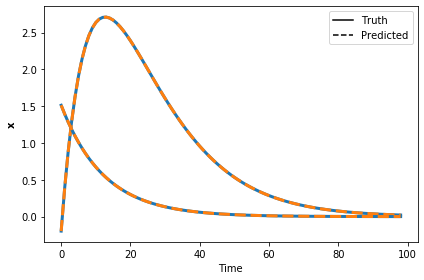

In [35]:
import matplotlib.lines as mlines

numStates = 2
traj = np.random.randint(0,nTraj/2)
init_index = traj*(nT)

predHorizon = nT - 1
psixf_pred = np.zeros((K.shape[0],predHorizon))
for i in range(0,predHorizon):
    psixf_pred[:,i:i+1] = np.dot(np.linalg.matrix_power(K,i),psixp_test[:,init_index:init_index+1]) 

mse = np.linalg.norm(psixp_test[:,init_index:init_index+predHorizon] - psixf_pred,'fro')/np.linalg.norm(psixp_test[:,init_index:init_index+predHorizon],'fro')
print('Trajectory ' + str(traj) + ', MSE: ' + str(round(mse,3)))

plt.figure()    
for i in range(1,numStates+1):
    plt.plot(psixp_test[i,init_index:init_index+predHorizon],lw=3,color='tab:blue');
    plt.plot(psixf_pred[i,0:predHorizon],'--',lw=3,color='tab:orange');
#     plt.plot(psixp_test[i,init_index:init_index+30],lw=6,color='tab:blue');
#     plt.plot(psixf_pred[i,0:30],'--',lw=6,color='tab:orange');
plt.xlabel('Time')
plt.ylabel('$\mathbf{x}$')
# plt.xlim([-4,200])
# plt.grid(True)
truthLeg = mlines.Line2D([], [], color='black',linestyle='-',marker='',label='Truth')
predLeg = mlines.Line2D([], [], color='black',linestyle='--',label='Predicted')
plt.legend(handles=[truthLeg,predLeg]);
# plt.savefig('repr_preds_traj'+str(traj)+'.pdf')

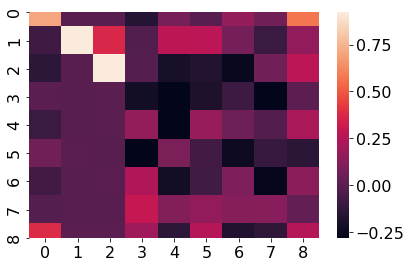

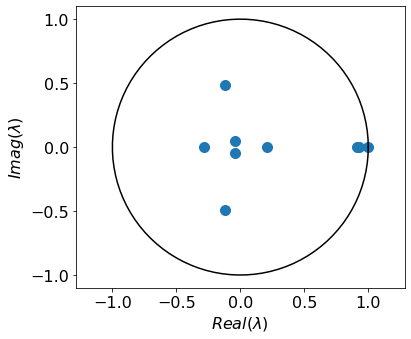

In [31]:
import seaborn as sn
plt.figure();
sn.heatmap(K);

import math
theta = np.linspace(0,2*math.pi,100)
plt.figure(figsize=(6,5));
plt.plot(np.real(np.linalg.eigvals(K)),np.imag(np.linalg.eigvals(K)),'o',ms=10);
plt.plot(np.cos(theta),np.sin(theta),color='black');
plt.ylabel('$Imag(\lambda)$');
plt.xlabel('$Real(\lambda)$');
plt.axis('equal');
# plt.savefig('toggleswitch_eigvals.pdf')